In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
import utils

2025-02-01 15:45:01.445252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-01 15:45:01.445325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-01 15:45:01.446733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 15:45:01.454669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Breast ultrasound dataset

Il dataset è composto da 780 immagini di ecografie al seno mediamente di 500x500, divise in normali, benigne e maligne. Siccome a noi interessa solo segmentare l'area interessata al tumore e non capire se è maligno o benigno, escludiamo questa classificazione e consideriamo il dataset come unico. Come ground truth usiamo una maschera in cui l'area bianca è l'area della lesione. Per aprire correttamente il dataset scaricatelo da Kaggle (https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset?resource=download), unzippatelo e mettetelo nella cartella del progetto.

In [2]:
train_pairs, val_pairs, test_pairs = utils.split_dataset(utils.create_list())

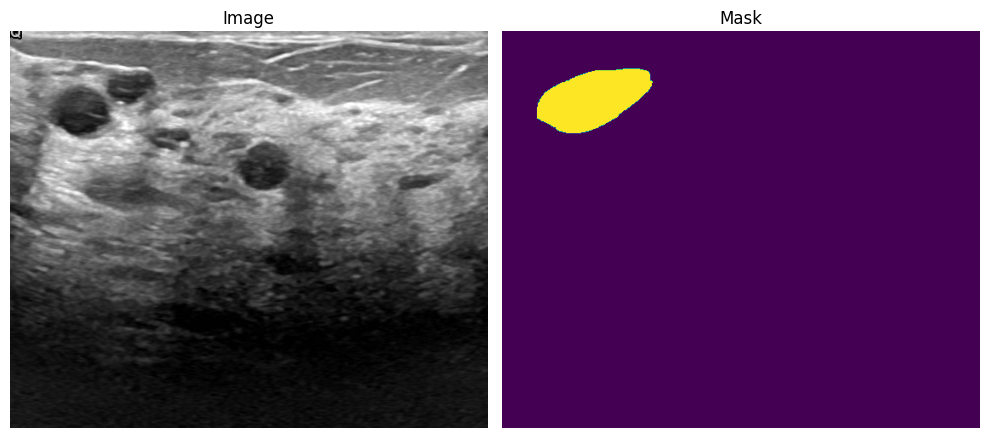

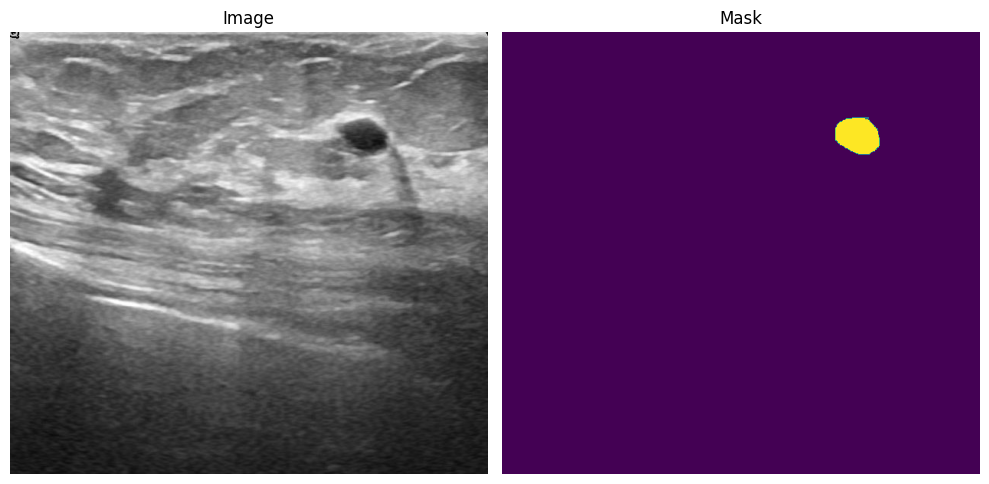

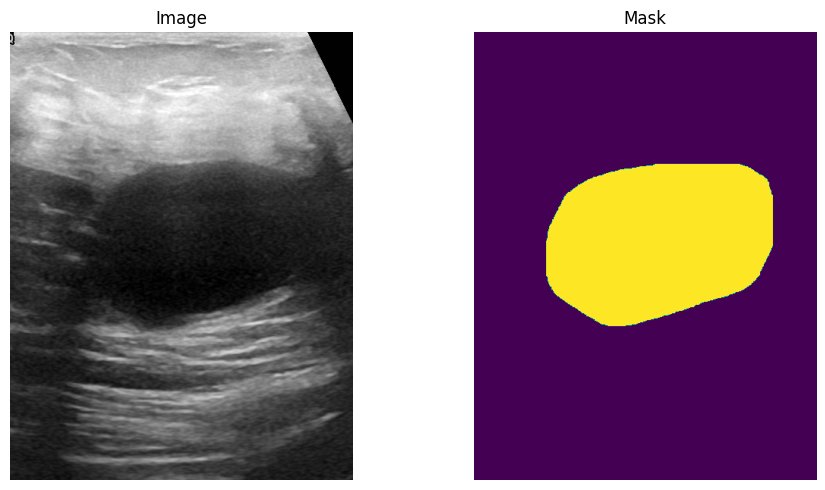

In [3]:
#visualize the first three image and mask pairs
for i in range(3):
    image_path, mask_path = train_pairs[i]
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display first image
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')

    # Display second image
    ax2.imshow(mask)
    ax2.set_title('Mask')
    ax2.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [3]:
train_dataset = utils.create_dataset(train_pairs, augment=True)
val_dataset = utils.create_dataset(val_pairs, augment=False)
test_dataset = utils.create_dataset(test_pairs, augment=False)

2025-02-01 15:45:10.052659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-01 15:45:10.062272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-01 15:45:10.062328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-01 15:45:10.066579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-01 15:45:10.066637: I external/local_xla/xla/stream_executor

Flipping horizontally


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Dataset:
  Image - min: -0.0838870108127594, max: 1.0967258214950562
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


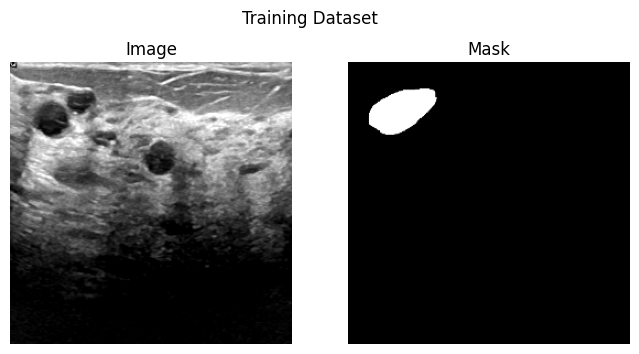

Validation Dataset:
  Image - min: 0.0, max: 0.8867174983024597
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


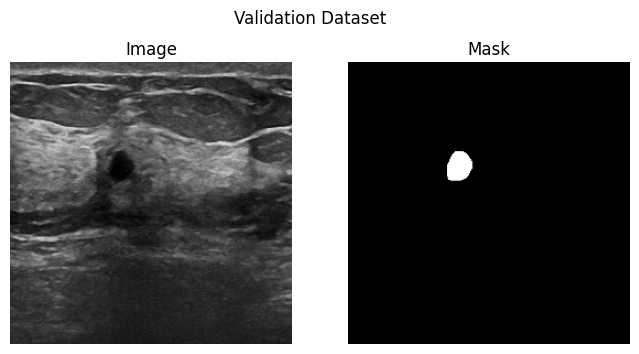

Testing Dataset:
  Image - min: 0.0, max: 1.0
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


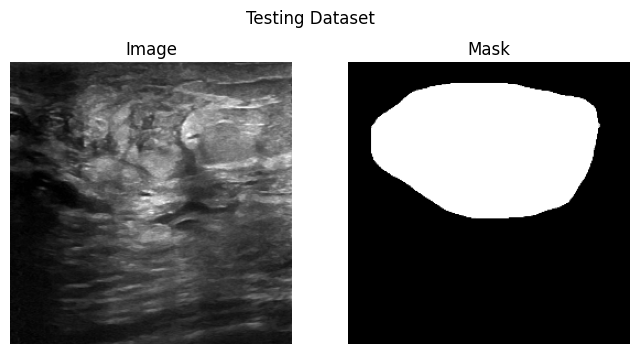

In [4]:
#check if data are correctly normalized and pairs are correctly matched
def show_image_mask(dataset, title):
    #take the first pair from the dataset
    for image, mask in dataset.take(1):
        #convert TensorFlow tensors to NumPy arrays
        image = image.numpy().squeeze()
        mask = mask.numpy().squeeze()

        image_min, image_max = np.min(image), np.max(image)
        mask_min, mask_max = np.min(mask), np.max(mask)

        print(f"{title}:")
        print(f"  Image - min: {image_min}, max: {image_max}")
        print(f"  Mask  - min: {mask_min}, max: {mask_max}")
        print()

        print(f"Image shape: {image.shape}")
        print(f"Mask shape: {mask.shape}")

        print(f"Image dtype: {image.dtype}")
        print(f"Mask dtype: {mask.dtype}")

        plt.figure(figsize=(8, 4))
        plt.suptitle(title)

        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()
        break

# Display for training, validation, and testing datasets
show_image_mask(train_dataset, "Training Dataset")
show_image_mask(val_dataset, "Validation Dataset")
show_image_mask(test_dataset, "Testing Dataset")

## ISIC Dataset 2017

Il dataset è scaricato da https://challenge.isic-archive.com/data/#2017: scaricate i training data, i validation data e i test data (sono abbastanza pesanti, ci metterà circa un'oretta), mentre per le maschere scaricate solo il primo file per ciascun set (la prima task è quella di segmentation, le altre non ci interessano). Il dataset si compone di 2000 immagini di tumori della pelle, anche qua divise tra maligni (melanoma) e benigni, ma questa distinzione non la consideriamo. Anche qui come prima, unzippate il dataset e mettetelo nella cartella del progetto.

In [3]:
train_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"))
val_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

Training Dataset:
  Image - min: 0.060431987047195435, max: 1.0
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


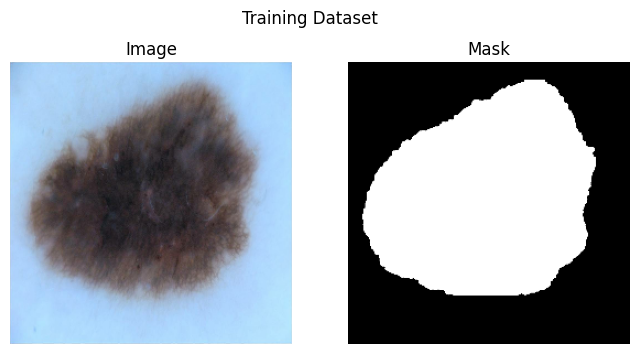

Validation Dataset:
  Image - min: 0.0, max: 0.9995864033699036
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


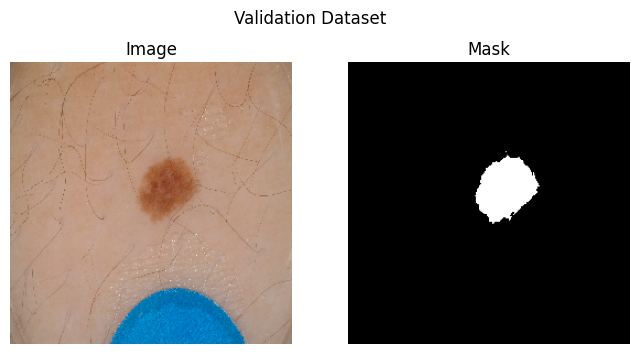

Test Dataset:
  Image - min: 0.02545955963432789, max: 0.9806066155433655
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


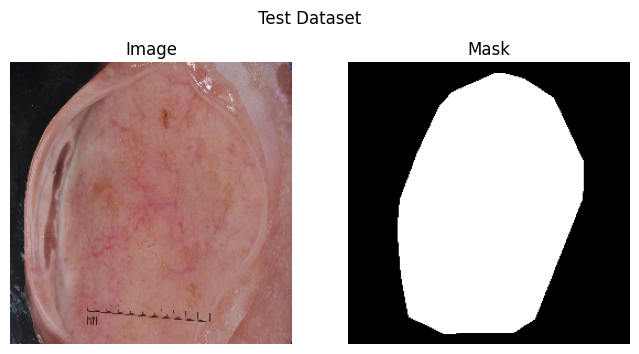

In [10]:
show_image_mask(train_dataset_skin, "Training Dataset")
show_image_mask(val_dataset_skin, "Validation Dataset")
show_image_mask(test_dataset_skin, "Test Dataset")

## Figshare brain tumor dataset

Il dataset è scaricabile da Kaggle (https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation/data). Si compone di 3064 immagini  con relative maschere per la segmentation del cervello ottenute tramite risonanza magnetica. Sono rappresentati tre tipi di tumore: meningioma, glioma e tumore pituitario. Il dataset è stato in parte già preprocessato dal tipo di Kaggle perché in origine l'immagine è 3D. Quando lo unzippate vi creerà una cartella "archive", io lo rinominerei "Brain_tumor_dataset" per chiarezza, per runnare il codice correttamente rinominatelo anche voi. Usiamo una funzione molto simile a quella per il dataset del cancro al seno.

In [2]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())

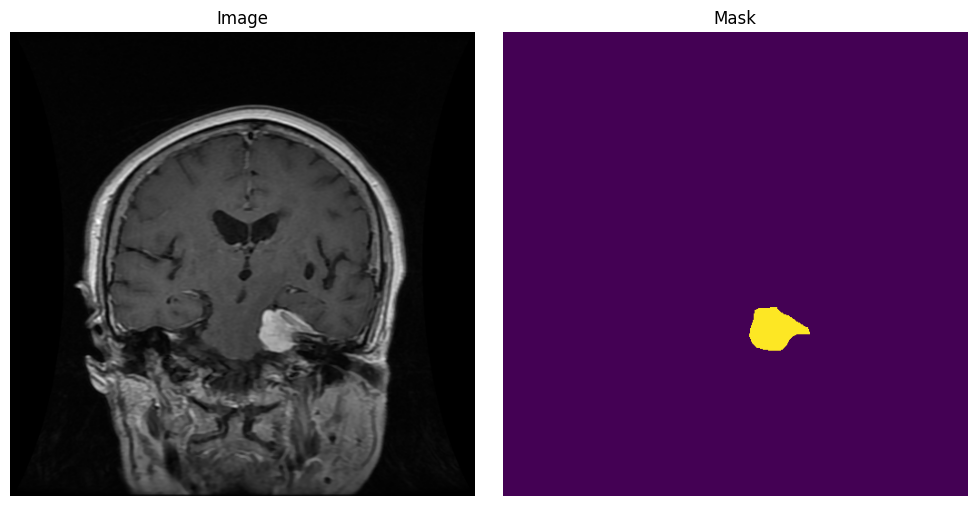

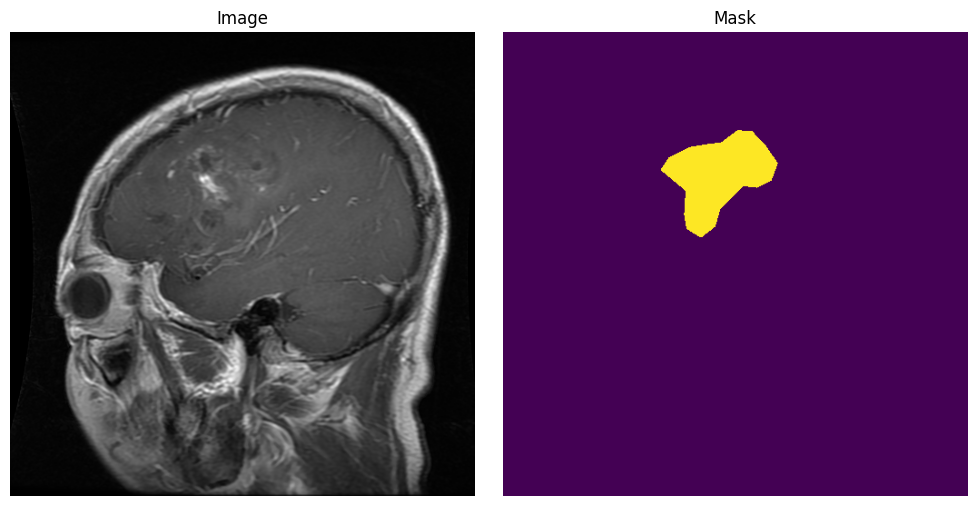

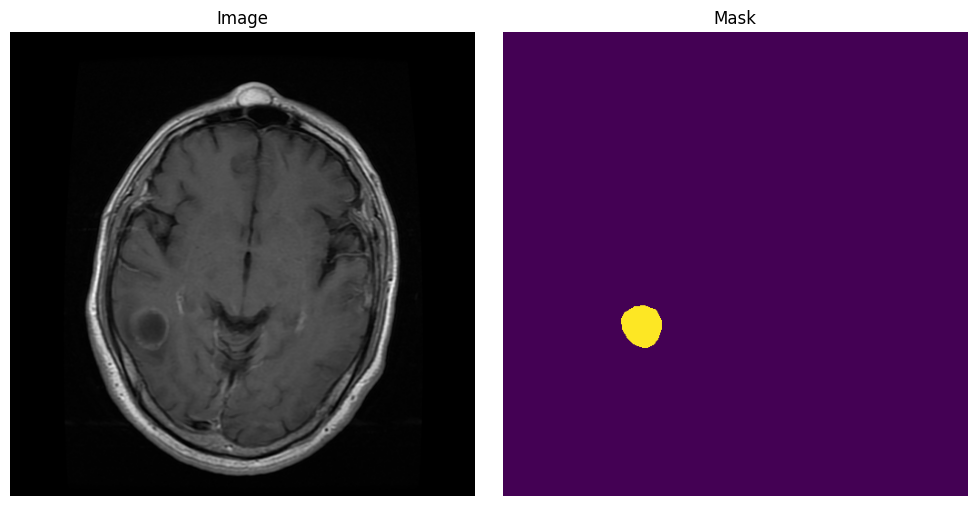

In [4]:
#visualize the first three image and mask pairs
for i in range(3):
    image_path, mask_path = train_pairs_brain[i]
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display first image
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')

    # Display second image
    ax2.imshow(mask)
    ax2.set_title('Mask')
    ax2.axis('off')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [6]:
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [8]:
train_dataset_brain = utils.create_dataset(train_pairs_brain)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

Training Dataset:
  Image - min: 0.0, max: 0.9735293984413147
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


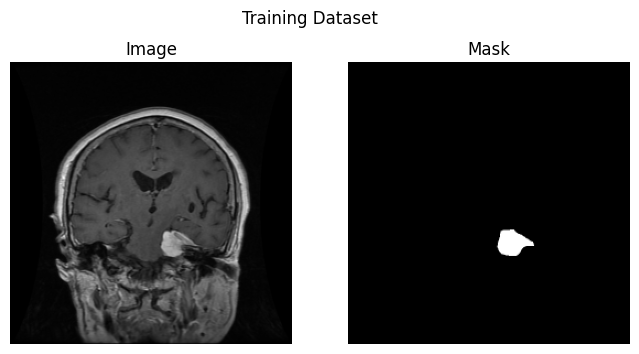

Validation Dataset:
  Image - min: 0.0, max: 0.9833333492279053
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


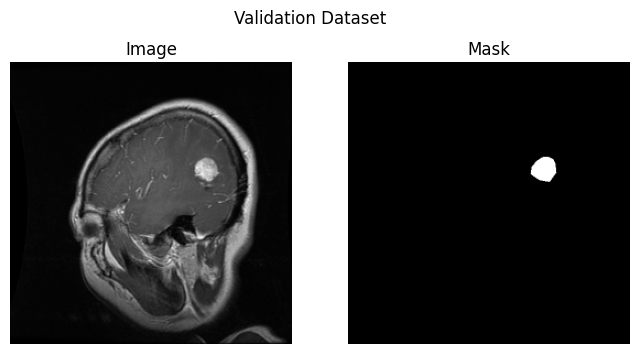

Test Dataset:
  Image - min: 0.0, max: 0.9901960492134094
  Mask  - min: 0.0, max: 1.0

Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: float32
Mask dtype: float32


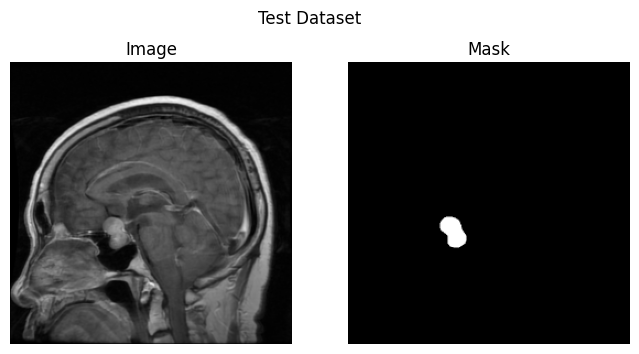

In [11]:
show_image_mask(train_dataset_brain, "Training Dataset")
show_image_mask(val_dataset_brain, "Validation Dataset")
show_image_mask(test_dataset_brain, "Test Dataset")